# Machine Learning Model Training - Universal Pipeline

This notebook provides a complete, universal machine learning pipeline that automatically adapts to your data.

## Objectives
- Load preprocessed datasets
- Automatically detect problem type (classification vs regression)
- Perform grid search on appropriate models
- Train best model on combined train+validation data
- Save the final model for production use

## Features
- ✅ **Universal**: Works with any target type (binary, multiclass, regression)
- ✅ **Automatic**: Detects problem type and applies appropriate models
- ✅ **Optimized**: Grid search with cross-validation
- ✅ **Production-ready**: Final model trained on maximum data
- ✅ **Persistent**: Save best model and configuration

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import custom functions
import sys
sys.path.append('../')
from functions.data_utils import load_datasets
from functions.ml_utils import (
    detect_problem_type, encode_target,
    get_models_config, get_scoring_metric, get_cv_strategy,
    grid_search, plot_model_comparison,
    train_final_model, evaluate_model,
    save_model_artifacts,
    create_test_set_analysis,
    show_feature_importance_detailed,
    print_final_summary
)

# Set up plotting
plt.style.use('dark_background')

## Configuration

Set up the configuration parameters for model training.

In [2]:
# Configuration parameters
DATASETS_PATH = '../data/datasets'  # Path to preprocessed datasets
MODELS_PATH = '../models'  # Path to save models
TARGET_TYPE = 'auto'  # 'auto', 'classification', 'regression'
CV_FOLDS = 5  # Number of cross-validation folds
RANDOM_STATE = 42  # For reproducibility
N_JOBS = -1  # Use all available cores

print(f"Datasets path: {DATASETS_PATH}")
print(f"Models path: {MODELS_PATH}")
print(f"Target type: {TARGET_TYPE}")
print(f"CV folds: {CV_FOLDS}")
print(f"Random state: {RANDOM_STATE}")

Datasets path: ../data/datasets
Models path: ../models
Target type: auto
CV folds: 5
Random state: 42


## Load Data

Load the preprocessed datasets and analyze the target variable.

In [3]:
# Load preprocessed datasets
X_train, X_val, X_test, y_train, y_val, y_test = load_datasets(DATASETS_PATH)

print("Dataset shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")
print(f"y_test: {y_test.shape}")

Datasets loaded successfully from ../data/datasets/
Loaded datasets:
  - X_train: (600, 27)
  - X_val: (200, 27)
  - X_test: (200, 27)
  - y_train: (600,)
  - y_val: (200,)
  - y_test: (200,)
Dataset shapes:
X_train: (600, 27)
X_val: (200, 27)
X_test: (200, 27)
y_train: (600,)
y_val: (200,)
y_test: (200,)


In [4]:
# Analyze target variable and detect problem type
problem_type = detect_problem_type(y_train, TARGET_TYPE)
print(f"Detected problem type: {problem_type}")

# Encode target if needed
y_train_proc, y_val_proc, y_test_proc, label_encoder = encode_target(
    y_train, y_val, y_test, problem_type
)

print(f"Processed target shapes: {y_train_proc.shape}, {y_val_proc.shape}, {y_test_proc.shape}")

Detected problem type: multiclass_classification
Encoding categorical target variable...
Target encoding mapping:
  Both -> 0
  Depression -> 1
  ME/CFS -> 2
Processed target shapes: (600,), (200,), (200,)


## Problem Type Detection and Target Encoding

Automatically detect the problem type and encode target if necessary.

## Model Selection and Grid Search Setup

Define models and hyperparameter grids based on the problem type.

In [5]:
# Create ML pipeline configuration
models_config = get_models_config(problem_type, RANDOM_STATE)
scoring_metric = get_scoring_metric(problem_type)
cv_strategy = get_cv_strategy(problem_type, y_train_proc, CV_FOLDS, RANDOM_STATE)

print(f"Models to evaluate: {list(models_config.keys())}")
print(f"Scoring metric: {scoring_metric}")
print(f"CV strategy: {type(cv_strategy).__name__}")

Models to evaluate: ['RandomForest', 'GradientBoosting', 'KNeighbors']
Scoring metric: f1_macro
CV strategy: StratifiedKFold


## Grid Search Execution

Perform grid search to find the best model and hyperparameters.

In [6]:
# Perform grid search to find best model and hyperparameters
grid_results, best_model_name, best_model = grid_search(
    X_train, y_train_proc, X_val, y_val_proc, 
    models_config, scoring_metric, cv_strategy, problem_type, N_JOBS
)

print(f"🏆 Best model: {best_model_name}")
print(f"🏆 Best validation score: {grid_results[best_model_name]['val_score']:.4f}")

Starting Grid Search...

🔍 Training RandomForest...
✅ RandomForest completed:
   Best params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
   Train score (CV): 0.9898
   Validation score: 0.9877

🔍 Training GradientBoosting...
✅ RandomForest completed:
   Best params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
   Train score (CV): 0.9898
   Validation score: 0.9877

🔍 Training GradientBoosting...
✅ GradientBoosting completed:
   Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
   Train score (CV): 0.9898
   Validation score: 0.9877

🔍 Training KNeighbors...
✅ GradientBoosting completed:
   Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
   Train score (CV): 0.9898
   Validation score: 0.9877

🔍 Training KNeighbors...
✅ KNeighbors completed:
   Best params: {'n_neighbors': 7, 'weights': 'distance'}
   Train score (CV): 0.8114
   Validation score: 0.8551


## Model Evaluation and Visualization

Evaluate all models and visualize the results.

Model Comparison Results:
              Model  Train_Score  Validation_Score
0      RandomForest       0.9898            0.9877
1  GradientBoosting       0.9898            0.9877
2        KNeighbors       0.8114            0.8551


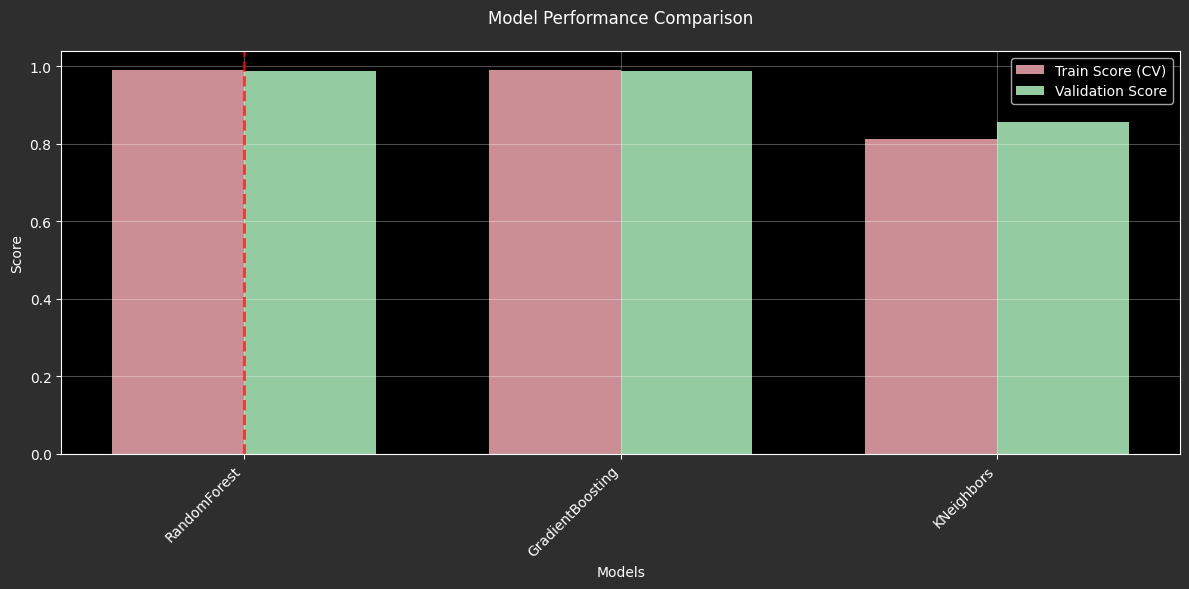

Model comparison completed and visualized.


In [7]:
# Evaluate and visualize model comparison results
plot_model_comparison(grid_results, best_model_name)
print("Model comparison completed and visualized.")

## Final Model Training

Retrain the best model on the combined train+validation dataset.

In [8]:
# Train final model on combined train+validation data
final_model = train_final_model(
    best_model_name, grid_results[best_model_name]['params'], 
    problem_type, X_train, X_val, y_train_proc, y_val_proc, RANDOM_STATE
)

# Evaluate on test set
test_results = evaluate_model(final_model, X_test, y_test_proc, problem_type, label_encoder)

print(f"Final model trained and evaluated on test set.")
print(f"Test set performance:")
for metric, value in test_results.items():
    if value is not None:
        print(f"  {metric}: {value:.4f}")

Final training data shape:
X_train_final: (800, 27)
y_train_final: (800,)

Retraining RandomForest with best parameters:
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training final model on combined data...

🎯 Final Model Performance on Test Set:
Accuracy: 0.9950
Precision (macro): 0.9921
Recall (macro): 0.9958
F1-score (macro): 0.9939

Detailed Classification Report:
              precision    recall  f1-score   support

        Both       0.98      1.00      0.99        41
  Depression       1.00      1.00      1.00        80
      ME/CFS       1.00      0.99      0.99        79

    accuracy                           0.99       200
   macro avg       0.99      1.00      0.99       200
weighted avg       1.00      0.99      1.00       200

Final model trained and evaluated on test set.
Test set performance:
  accuracy: 0.9950
  precision: 0.9921
  recall: 0.9958
  f1_score: 0.9939


## Save Final Model and Artifacts

Save the trained model and all necessary artifacts for production use.

🎯 Test Set Performance Analysis:


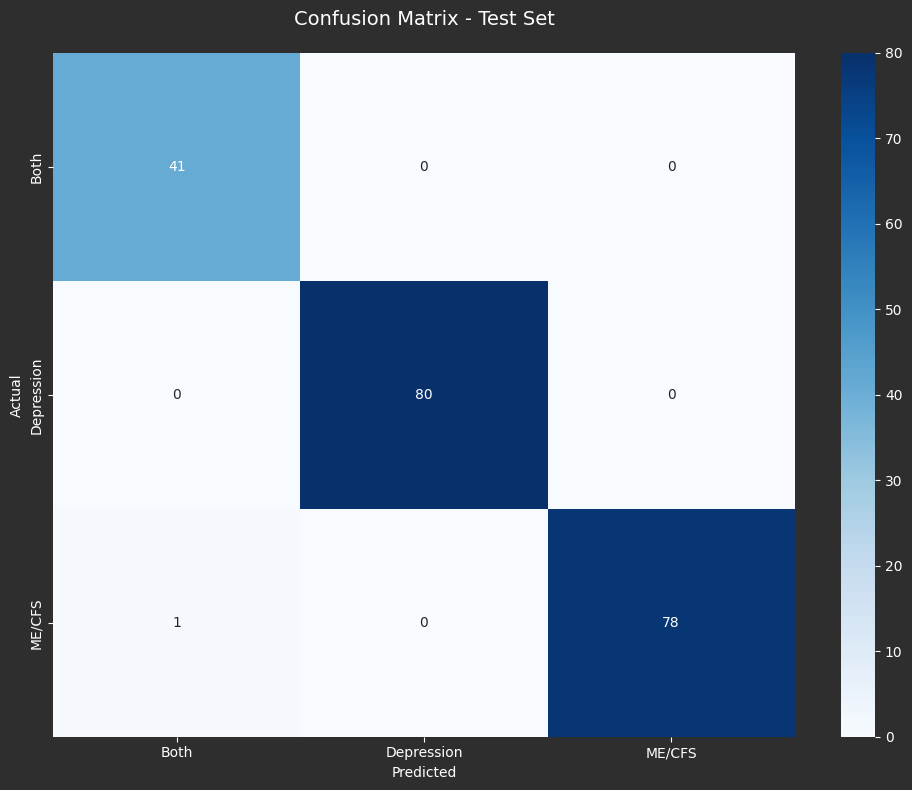


📋 Detailed Classification Report:
              precision    recall  f1-score   support

        Both       0.98      1.00      0.99        41
  Depression       1.00      1.00      1.00        80
      ME/CFS       1.00      0.99      0.99        79

    accuracy                           0.99       200
   macro avg       0.99      1.00      0.99       200
weighted avg       1.00      0.99      1.00       200

🔍 Feature Importance Analysis:
📊 Top 15 Most Important Features:
📊 Top 15 Most Important Features:


,feature,importance
5,depression_phq9_score,0.3562
9,pem_present,0.3492
6,fatigue_severity_scale_score,0.1459
2,brain_fog_level,0.0190
1,sleep_quality_index,0.0176
3,physical_pain_score,0.0161
4,stress_level,0.0149
8,hours_of_sleep_per_night,0.0146
0,age,0.0140
7,pem_duration_hours,0.0140


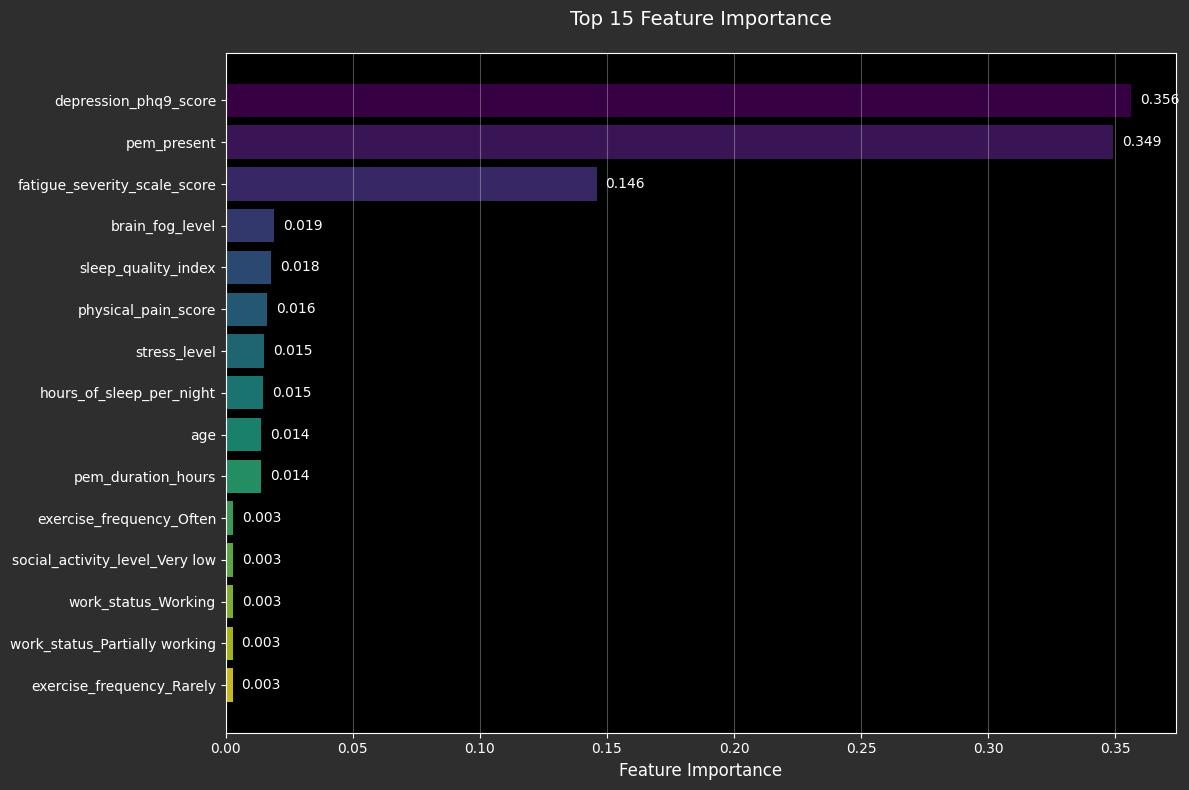

✅ Model and artifacts saved successfully!
📁 Final model: ../models/final_model.pkl
📁 Model metadata: ../models/model_metadata.pkl

📊 Model Summary:
   Model: RandomForest
   Problem type: multiclass_classification
   Features: 27
🎉 FINAL ML PIPELINE SUMMARY
📊 Problem Type: multiclass_classification
🏆 Best Model: RandomForest
📈 Features: 27
📦 Dataset Split:
   - Training: 600 samples
   - Validation: 200 samples
   - Test: 200 samples
   - Total: 1000 samples

📈 Best Parameters:
   max_depth: 10
   min_samples_leaf: 1
   min_samples_split: 2
   n_estimators: 100

📊 Final Test Performance:
   accuracy: 0.9950
   precision: 0.9921
   recall: 0.9958
   f1_score: 0.9939

💾 Saved Artifacts:
   📁 Model: ../models/final_model.pkl
   📁 Metadata: ../models/model_metadata.pkl

✅ Pipeline completed successfully!
🚀 Model ready for production deployment!


In [9]:
# Create detailed test set analysis (passare y_test originale per la funzione)
create_test_set_analysis(final_model, X_test, y_test, problem_type, label_encoder)

# Show detailed feature importance analysis (using only the best visualization)
if hasattr(final_model, 'feature_importances_'):
    show_feature_importance_detailed(final_model, X_train.columns.tolist())

# Save model and artifacts
save_model_artifacts(
    final_model, best_model_name, problem_type, 
    grid_results[best_model_name]['params'], X_train, grid_results,
    test_results, label_encoder, MODELS_PATH
)

# Print comprehensive final summary
print_final_summary(
    problem_type, best_model_name, grid_results[best_model_name]['params'],
    test_results, X_train, X_val, X_test, MODELS_PATH
)